In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [103]:
listings = pd.read_csv('../data/Airbnb_dataset_chicago/19_March_2023/listings_detail.csv')
reviews = pd.read_csv('../data/Airbnb_dataset_chicago/19_March_2023/reviews_detail.csv')

In [104]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2384,25218143,2015-01-09,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,2384,28475392,2015-03-24,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,2384,30273263,2015-04-19,26101401,Patrick,The reservation was canceled 80 days before ar...
3,2384,30974202,2015-04-30,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
4,2384,31363208,2015-05-04,31293837,SuJung,Rebecca was an absolutely wonderful host.\r<br...


In [105]:
#  <br/> and \r 
reviews['comments'] = reviews['comments'].str.replace('<br/>', '')
reviews['comments'] = reviews['comments'].str.replace('\r', '')
# drop rows with null comments
reviews = reviews.dropna(subset=['comments'])

In [106]:
# combine comments which have the same listing_id
reviews_listings = reviews.groupby('listing_id')['comments'].apply(' '.join).reset_index()
reviews_listings.head()

,listing_id,comments
0,2384,it's a wonderful trip experience. I didn't exc...
1,7126,We really enjoyed our stay at Sarah's place! ...
2,10945,"I stayed at the Biddle 1 for a few days, and t..."
3,12140,My wife and I spent our 5th year anniversary a...
4,24833,Shan was great and greeted us like we were lon...


In [107]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [108]:
# select the id, scrape_id, host_id,  latitude, longitude, price, review_scores
listings_clean = listings[['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'price', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
listings_clean["INFOcombined"] = (
    "Name:" + listings.name.str.strip() + "; Description: " + listings.description.str.strip() + "; Neighborhood Overview: " + listings.neighborhood_overview.str.strip() + "; Host Name: " + listings.host_name.str.strip() + "; Host About: " + listings.host_about.str.strip() + "; Amenities: " + listings.amenities.str.strip()
)
# drop the rows with missing values
listings_clean = listings_clean.dropna()

/tmp/ipykernel_9978/855177951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_clean["INFOcombined"] = (


In [109]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# test the model
embeddings = model.encode(sentences)
type(embeddings)


numpy.ndarray

In [110]:
# combine the reviews to the listings_clean as a column
listings_clean = listings_clean.merge(reviews_listings, left_on='id', right_on='listing_id', how='left')
# drop the listing_id column
listings_clean = listings_clean.drop(columns=['listing_id'])

In [111]:
# get the embeddings for each listing
listings_clean['INFO_embeddings'] = listings_clean['INFOcombined'].apply(lambda x: model.encode(x))
listings_clean['Comments_embeddings'] = listings_clean['comments'].apply(lambda x: model.encode(x))

In [121]:
listings_clean.head()

,id,scrape_id,host_id,latitude,longitude,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,INFOcombined,comments,INFO_embeddings,Comments_embeddings,review_scores_rating_boxcox,cluster,review_scores_rating_class
0,2384,20230319041143,2613,41.78790,-87.58780,$90.00,4.99,4.98,4.99,4.99,4.99,4.96,4.93,Name:Hyde Park - Walk to UChicago; Description...,it's a wonderful trip experience. I didn't exc...,"[0.06073645, -0.047686566, 0.025650807, 0.0084...","[0.07343577, 0.028138738, 0.05383891, 0.074819...",0.974215,2,5
1,1772920,20230319041143,9297431,41.94842,-87.65307,$379.00,4.67,4.67,4.75,4.42,4.75,4.92,4.58,Name:3 Bedroom Across from Wrigley Field AllSt...,This is a beautiful new place. Our family cook...,"[0.0517006, -0.059134144, -0.04802967, 0.00372...","[0.06650951, -0.004386352, 0.04927142, 0.09019...",0.410276,3,5
2,1773021,20230319041143,9297431,41.94774,-87.65421,$479.00,4.92,4.92,4.92,4.96,4.88,5.00,4.85,Name:4 Bedroom Across from Wrigley Field Stadi...,Great place! Very large and clean. Beds are ve...,"[0.10867502, 0.0029849908, -0.034289863, 0.010...","[0.069732755, -0.05834745, 0.03422368, 0.09965...",0.810210,0,5
3,1773025,20230319041143,9297431,41.94750,-87.65420,$479.00,4.86,5.00,4.81,4.95,4.90,5.00,4.76,Name:4 Bedroom Across from Wrigley Field Legen...,This place was amazing. Host was extremely att...,"[0.10112072, 0.0018416203, -0.021964462, 0.018...","[0.05902016, -0.048730966, 0.010970407, 0.0805...",0.690344,3,5
4,1810118,20230319041143,9483312,41.77738,-87.60041,$79.00,4.89,4.93,4.93,4.96,4.96,4.48,4.88,Name:LARGE Private 1BR/Full Bath near U of Chi...,Ryan is a great host. Picked me up and provide...,"[0.06257135, -0.030963605, 0.09453465, 0.00944...","[0.0544252, -0.002359957, 0.011108118, 0.07203...",0.748063,2,5


array([[<Axes: title={'center': 'review_scores_rating'}>]], dtype=object)

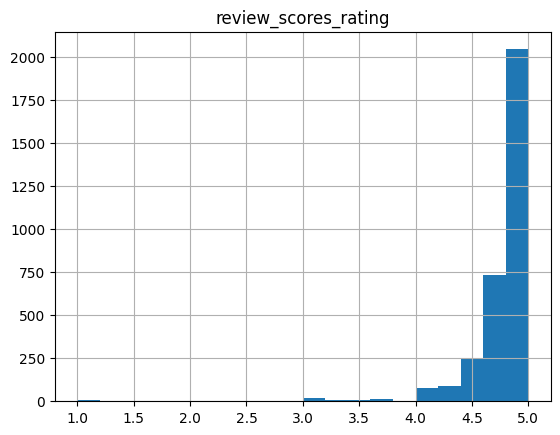

In [113]:
# plot histgram of  the review scores
listings_clean.hist(column='review_scores_rating', bins=20)

array([[<Axes: title={'center': 'review_scores_rating_boxcox'}>]],
      dtype=object)

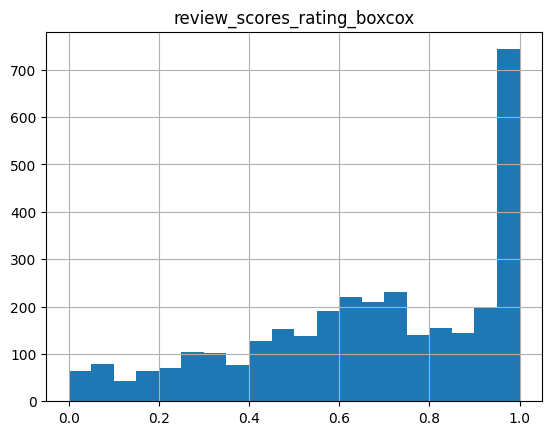

In [114]:
# Box-Cox Transformation
from scipy import stats
listings_clean['review_scores_rating_boxcox'], fitted_lambda = stats.boxcox(listings_clean['review_scores_rating'], lmbda=None)
# Normalize the review_scores_rating_boxcox
listings_clean['review_scores_rating_boxcox'] = (listings_clean['review_scores_rating_boxcox'] - listings_clean['review_scores_rating_boxcox'].min()) / (listings_clean['review_scores_rating_boxcox'].max() - listings_clean['review_scores_rating_boxcox'].min())
# plot
listings_clean.hist(column='review_scores_rating_boxcox', bins=20)

In [115]:
matrix = listings_clean['Comments_embeddings'].tolist()
matrix = np.array(matrix)
matrix.shape

(3253, 384)

In [120]:
# classify the listings into 5 degree of review_scores_rating
listings_clean['review_scores_rating_class'] = pd.cut(listings_clean['review_scores_rating'], bins=5, labels=[1, 2, 3, 4, 5])
listings_clean['review_scores_rating_class'].value_counts()


review_scores_rating_class
5    3106
4     108
3      26
1       8
2       5
Name: count, dtype: int64

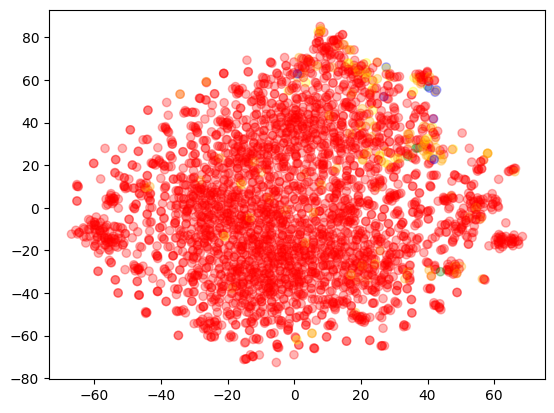

In [122]:
# Data visualization in 2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, random_state=42, init='random', perplexity=15, learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ['blue', 'green', 'yellow', 'orange', 'red'] 
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
# color indices is class value - 1
color_indices = [int(x) - 1 for x in listings_clean['review_scores_rating_class'].tolist()]

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
